In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow 
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [91]:
store_sales = pd.read_csv("../Data/Forcast.csv")

In [92]:
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [93]:
store_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [94]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [95]:
store_sales = store_sales.drop(['store', 'item'], axis=1)

In [96]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [97]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [98]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [99]:
store_sales['date'] = store_sales['date'].dt.to_period('M')


In [100]:
monthly_sales = store_sales.groupby('date').sum().reset_index()


In [101]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


Text(0.5, 1.0, 'Monthly Sales')

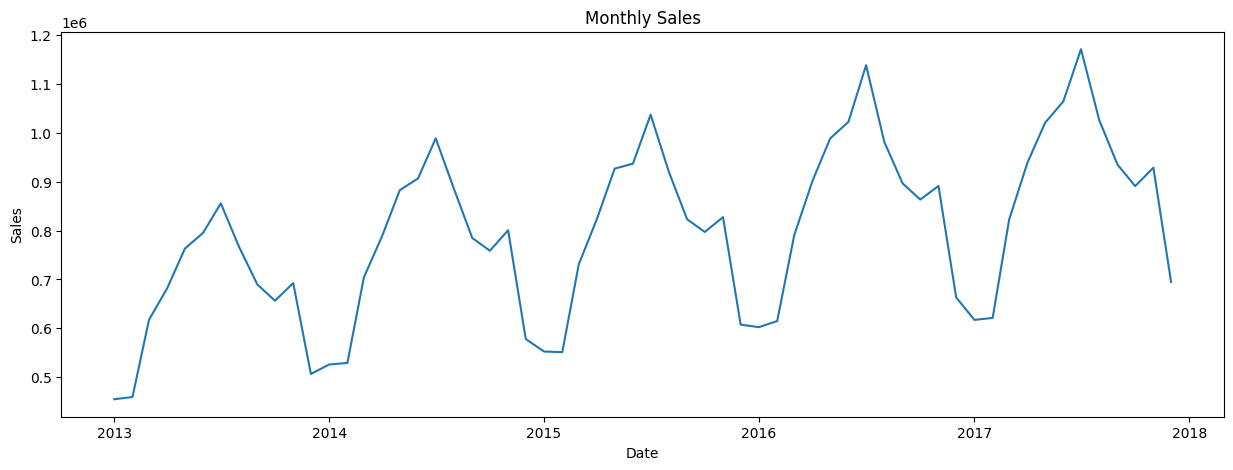

In [102]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales')


In [103]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


Text(0.5, 1.0, 'Monthly Sales')

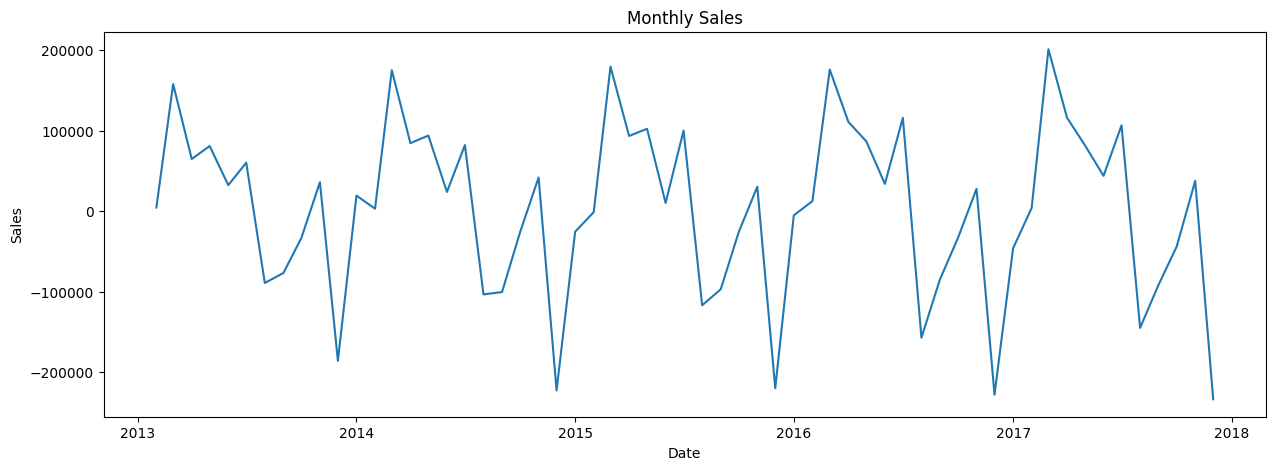

In [104]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales')

In [105]:
supervised_data  = monthly_sales.drop(['date', 'sales'],axis=1)

In [106]:
for i in range(1,13):
    col_name = 'Month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [107]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train data set : ", train_data.shape)
print("Test data set : ", test_data.shape)

Train data set :  (35, 13)
Test data set :  (12, 13)


In [108]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


In [109]:
print("traindata", train_data)

traindata [[ 0.13408606  0.20344758 -0.81758535  0.28633667 -0.05850103 -0.27488947
  -0.33606217  0.40696724  0.26794062  0.50957454  0.42966779  0.8922929
   0.12955024]
 [ 0.97816867  0.12267595  0.20344758 -0.81758535  0.28633667 -0.05850103
  -0.27488947 -0.33606217  0.40696724  0.26794062  0.50957454  0.42966779
   0.8922929 ]
 [ 0.53383488  0.977881    0.12267595  0.20344758 -0.81758535  0.28633667
  -0.05850103 -0.27488947 -0.33606217  0.40696724  0.26794062  0.50957454
   0.42966779]
 [ 0.5797052   0.52769224  0.977881    0.12267595  0.20344758 -0.81758535
   0.28633667 -0.05850103 -0.27488947 -0.33606217  0.40696724  0.26794062
   0.50957454]
 [ 0.23630084  0.574167    0.52769224  0.977881    0.12267595  0.20344758
  -0.81758535  0.28633667 -0.05850103 -0.27488947 -0.33606217  0.40696724
   0.26794062]
 [ 0.52183992  0.22623761  0.574167    0.52769224  0.977881    0.12267595
   0.20344758 -0.81758535  0.28633667 -0.05850103 -0.27488947 -0.33606217
   0.40696724]
 [-0.38860993

In [110]:
X_train, y_train =train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]

y_train = y_train.ravel()
y_test = y_test.ravel()

print("Shapes ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shapes  (35, 12) (35,) (12, 12) (12,)


In [111]:
sales_date = monthly_sales['date'][-12:].reset_index(drop= True)
predict_df = pd.DataFrame(sales_date)
predict_df

,date
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
5,2017-06-01
6,2017-07-01
7,2017-08-01
8,2017-09-01
9,2017-10-01


In [112]:
act_sales = monthly_sales['sales'][-13:].to_list()
act_sales

[663411,
 617306,
 621369,
 822667,
 938862,
 1020686,
 1064624,
 1171393,
 1026403,
 935263,
 891160,
 928837,
 695170]

In [113]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pre = lr_model.predict(X_test)
lr_pre

array([ 0.0427074 ,  0.17284957,  1.09083796,  0.71220971,  0.58376708,
        0.33753568,  0.79053303, -0.71169155, -0.29772672, -0.01470231,
        0.24425358, -1.02944627])

In [114]:
lr_pre = lr_pre.reshape(-1,1)


In [115]:
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)



In [116]:
result_list = []

for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
    
lr_pre_series = pd.Series(result_list,name = "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

print(predict_df)    

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [119]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print(lr_mse, lr_mae, lr_r2)

16221.272385416896 12433.184266490784 0.9906152516380968


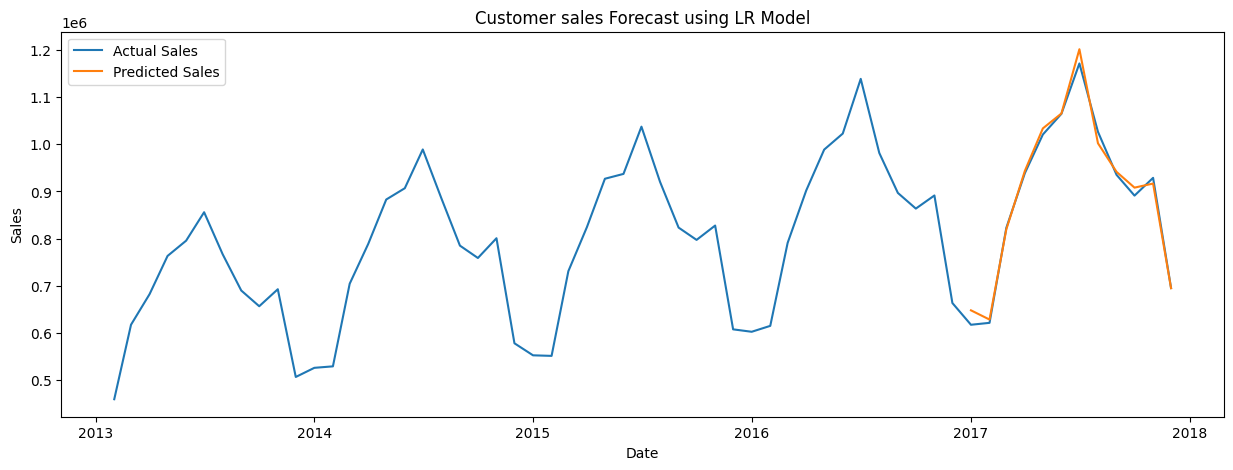

In [120]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'])

plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.legend(['Actual Sales', "Predicted Sales"])
plt.show()